In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [22]:
import mesh_tensorflow as mtf
import tensorflow as tf

In [4]:
klin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[1]

In [7]:
# Define the cluster
cluster = tf.train.ClusterSpec({"mesh": ["localhost:2222", "localhost:2223"]})

In [23]:
# import flowpm.mesh_ops as mpm
import flowpm
import flowpm.mesh_utils as mpu
import flowpm.mtfpm as fpm

graph = mtf.Graph()
mesh = mtf.Mesh(graph, "my_mesh")

batch_size = 2
nc = 128
boxsize=200

stages = np.linspace(0.1, 1.0, 10, endpoint=True)

kvec = flowpm.kernels.fftk([nc, nc, nc], symmetric=False)

batch_dim = mtf.Dimension("batch", batch_size)
x_dim = mtf.Dimension("nx", nc)
y_dim = mtf.Dimension("ny", nc)
z_dim = mtf.Dimension("nz", nc)

pk_dim = mtf.Dimension("npk", len(plin))
pk = mtf.import_tf_tensor(mesh, plin.astype('float32'), shape=[pk_dim])

kx = mtf.import_tf_tensor(mesh, kvec[0].squeeze().astype('float32'), shape=[x_dim])
ky = mtf.import_tf_tensor(mesh, kvec[1].squeeze().astype('float32'), shape=[y_dim])
kz = mtf.import_tf_tensor(mesh, kvec[2].squeeze().astype('float32'), shape=[z_dim])
kv = [kx, ky, kz]

In [ ]:
# Create initial conditions
initial_conditions = fpm.linear_field(mesh, [batch_dim, x_dim, y_dim, z_dim], boxsize, pk, kv)

# LPT evolution to a=0.1
state = fpm.lpt_init(initial_conditions , 0.1, kv, [x_dim], [2])

# Nbody all the way to a=1
final_state = fpm.nbody(state,  stages, [batch_dim, x_dim, y_dim, z_dim], kv,  [x_dim], [2])     

# Let's paint the result back on the grid for visualization
final_field = mpu.cic_paint(mtf.zeros_like(initial_conditions), final_state[0],  [x_dim], [2])

Note that for now, we still need to manually specify which dimension is splitted, and in how many splits,
We just need to implement a Mesh Operation for CiC painting and reading

In [ ]:
devices = ["/job:mesh/task:%d"%i for i in range(cluster.num_tasks("mesh"))]
mesh_shape = [("row", 2), ("col", 1)]
layout_rules = [("nx", "row"), ("ny", "col")]

mesh_impl = mtf.placement_mesh_impl.PlacementMeshImpl(
    mesh_shape, layout_rules, devices)

lowering = mtf.Lowering(graph, {mesh:mesh_impl})

tf_initial_field = lowering.export_to_tf_tensor(initial_conditions)
tf_final_field = lowering.export_to_tf_tensor(final_field)

In [15]:
with tf.Session("grpc://localhost:2222") as sess:
    inif, finif = sess.run([tf_initial_field, tf_final_field])

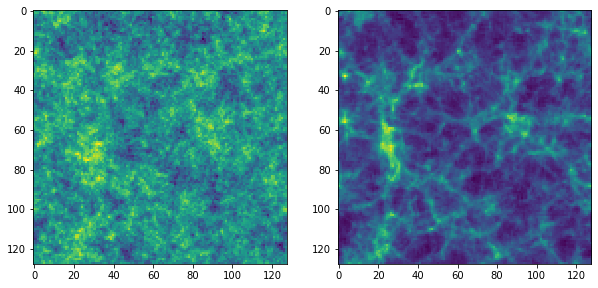

In [21]:
figure(figsize=(10, 5))
subplot(121)
imshow(inif[0,:,:,:].sum(axis=0));
subplot(122)
imshow((finif[0,:,:,:]).sum(axis=0));